In [ ]:
import torch
import torchtuples as tt
import numpy as np
import pandas as pd
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong

In [ ]:

# from pycox.models.transforms import MLPVanilla

# Load dataset
file_path = "S1Data.csv"
df = pd.read_csv(file_path)

# Define features and target variables
cols_standardize = ['Age', 'Ejection.Fraction', 'Sodium', 'Creatinine', 'Pletelets', 'CPK']
cols_categorical = ['Gender', 'Smoking', 'Diabetes', 'BP', 'Anaemia']

y_cols = ['TIME', 'Event']
X = df[cols_standardize + cols_categorical]
y = df[y_cols]

# Standardize continuous variables
scaler = StandardScaler()
X[cols_standardize] = scaler.fit_transform(X[cols_standardize])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

time, event = y_train['TIME'].values, y_train['Event'].values
labtrans = DeepHitSingle.label_transform(10)
y_train = labtrans.fit_transform(time, event)

time_test, event_test = y_test['TIME'].values, y_test['Event'].values
y_test = labtrans.transform(time_test, event_test)

# Define a Transformer-based neural network
def make_model(in_features, num_nodes=[64, 64], out_features=labtrans.out_features):
    return tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm=True, dropout=0.1)

# Initialize DeepHitSingle model
in_features = X_train.shape[1]
net = make_model(in_features)
model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

# Train model
batch_size = 32
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=10)]
loss = model.fit(X_train, y_train, batch_size, epochs, callbacks, val_data=(X_test, y_test))

# Predict survival probabilities
surv = model.predict_surv_df(X_test)

# Evaluate model
ev = EvalSurv(surv, time_test, event_test, censor_surv='km')
c_index = ev.concordance_td()
print("Concordance Index:", c_index)

In [ ]:
# Load the dataset
df = pd.read_csv('S1Data.csv')

In [ ]:
# df.head()
print(df.dtypes)

In [ ]:
# Preprocess data
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(['TIME', 'Event'], axis=1))
durations = df['TIME'].values
events = df['Event'].values

In [ ]:
# Define transformer-based survival model
class SurvivalTransformer(torch.nn.Module):
    def __init__(self, input_dim, num_embeddings=8, num_heads=4):
        super().__init__()
        self.embedding = torch.nn.Linear(input_dim, num_embeddings)
        self.transformer = torch.nn.TransformerEncoderLayer(
            d_model=num_embeddings, nhead=num_heads
        )
        self.output = torch.nn.Linear(num_embeddings, 1)  # Hazard prediction

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        return self.output(x)

In [ ]:
# Split the data into training and validation sets
X_train, X_val, durations_train, durations_val, events_train, events_val = train_test_split(
    X, durations, events, test_size=0.2, random_state=42
)

# Train the model with explicitly defined validation data
model.fit(
    X_train, 
    (durations_train, events_train), 
    epochs=50, 
    val_data=(X_val, (durations_val, events_val)), 
    batch_size=32
)

Dataset Shape: (2030, 13)
Data Types:
 TIME                 float64
Gender               float64
Smoking              float64
Diabetes             float64
BP                   float64
Anaemia              float64
Age                  float64
Ejection.Fraction    float64
Sodium               float64
Creatinine           float64
Pletelets            float64
CPK                  float64
Event                float64
dtype: object

Missing Values:
 TIME                 0
Gender               0
Smoking              0
Diabetes             0
BP                   0
Anaemia              0
Age                  0
Ejection.Fraction    0
Sodium               0
Creatinine           0
Pletelets            0
CPK                  0
Event                0
dtype: int64

Data Summary:
               TIME       Gender      Smoking     Diabetes           BP  \
count  2030.000000  2030.000000  2030.000000  2030.000000  2030.000000   
mean     82.438916     0.539409     0.183251     0.294581     0.285222   
st

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 16, 1)     │          2 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 1)     │          0 │ input_layer[0][0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 16, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 16, 1)     │          5 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 1)     │          0 │ add[0][0],        │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 1)     │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 16, 1)     │          0 │ add_1[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 1)     │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 16, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 16, 1)     │          5 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 16, 1)     │          0 │ add_2[0][0],      │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 1)     │          2 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 16, 1)     │          0 │ add_3[0][0],      │
│                     │                   │            │ multi_head_atten

 Total params: 37,321 (145.79 KB)

 Trainable params: 37,321 (145.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.8126 - auc: 0.5131 - loss: 0.9343 - precision: 0.9052 - recall: 0.8907 - val_accuracy: 0.9138 - val_auc: 0.4903 - val_loss: 0.2974 - val_precision: 0.9138 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8971 - auc: 0.4986 - loss: 0.4407 - precision: 0.8971 - recall: 1.0000 - val_accuracy: 0.9138 - val_auc: 0.4759 - val_loss: 0.3020 - val_precision: 0.9138 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8920 - auc: 0.5130 - loss: 0.4404 - precision: 0.8920 - recall: 1.0000 - val_accuracy: 0.9138 - val_auc: 0.4996 - val_loss: 0.3076 - val_precision: 0.9138 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8997 - auc: 0.5318 - loss: 0.4093 - precision: 0.8997 - recall: 1.0000 - val_accuracy: 0.9138 - val_auc: 0.5079 - val_loss: 0.3108 - va

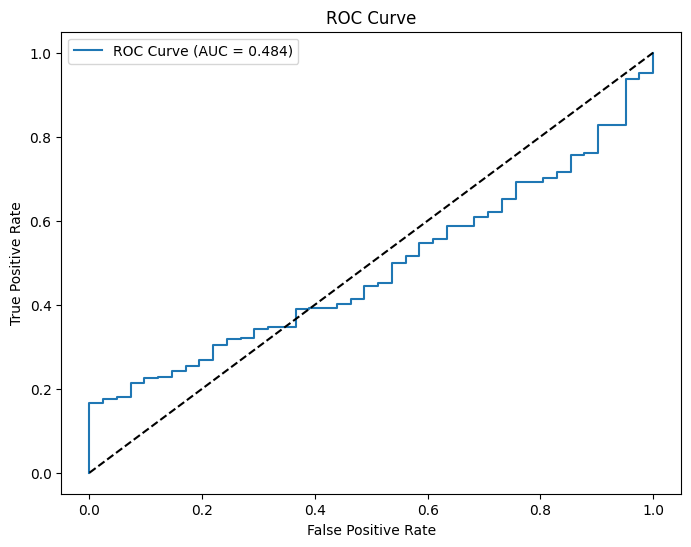

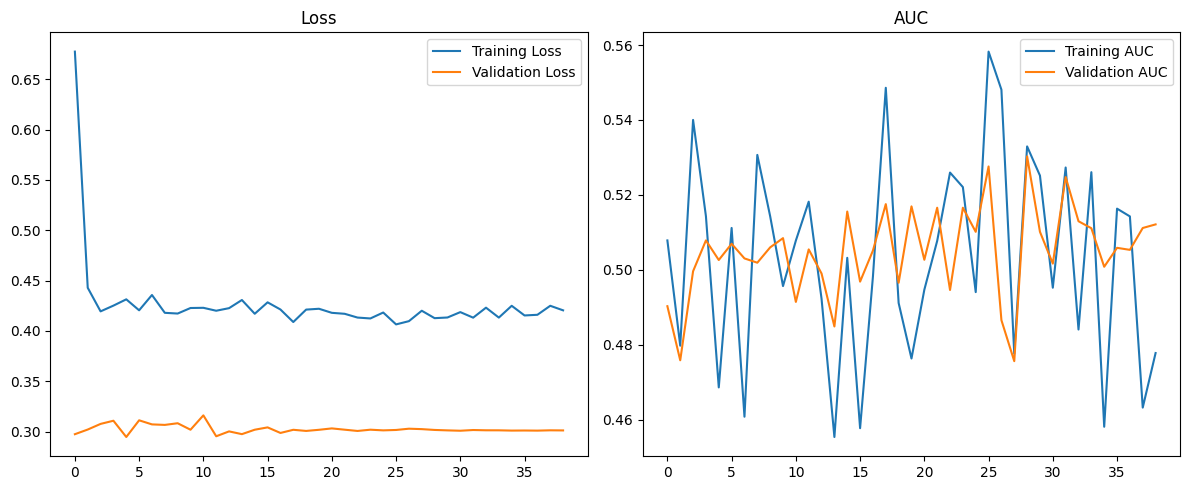


3. Analyzing feature importance...

4. Performing survival analysis...

5. Done!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading and Initial Exploration
#----------------------------------------
# Load the CSV data (replace with your actual file loading mechanism if needed)
df = pd.read_csv('augmented_heart_failure_data.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("Data Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Summary:\n", df.describe())

# 2. Data Preprocessing
#---------------------
# Identify target variable, and split features into categorical and numerical
target = 'Event'  # Event is the death event (0=survived, 1=died)
time_column = 'TIME'  # Time is the follow-up period

# Features to use in the model
categorical_features = ['Gender', 'Smoking', 'Diabetes', 'BP', 'Anaemia']
numerical_features = ['Age', 'Ejection.Fraction', 'Sodium', 'Creatinine', 
                      'Pletelets', 'CPK']

# Create X (features) and y (target)
X = df.drop([target, time_column], axis=1)
y = df[target]
time_data = df[time_column]

# Split the data into training and testing sets, stratifying by the target variable
X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(
    X, y, time_data, test_size=0.2, random_state=42, stratify=y
)

# Create preprocessing pipelines for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# If using a transformer model directly, reshape data to sequence format
# Each patient's data will be treated as a sequence of features
sequence_length = X_train_processed.shape[1]
X_train_seq = X_train_processed.reshape(X_train_processed.shape[0], sequence_length, 1)
X_test_seq = X_test_processed.reshape(X_test_processed.shape[0], sequence_length, 1)

# 3. Exploratory Data Analysis
#----------------------------
def plot_eda():
    # Correlation heatmap for numerical features
    plt.figure(figsize=(12, 10))
    corr = df[numerical_features + [target, time_column]].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap of Numerical Features')
    plt.tight_layout()
    plt.show()
    
    # Distribution of target variable
    plt.figure(figsize=(8, 6))
    sns.countplot(x=target, data=df)
    plt.title('Distribution of Heart Failure Events')
    plt.show()
    
    # Survival analysis visualization
    plt.figure(figsize=(10, 6))
    for event in [0, 1]:
        subset = df[df[target] == event]
        sns.kdeplot(subset[time_column], label=f'Event={event}')
    plt.title('Time Distribution by Event')
    plt.xlabel('Follow-up Time (days)')
    plt.legend(['Survived', 'Died'])
    plt.show()

# Uncomment to run EDA plots
# plot_eda()

# 4. Define Transformer-based Model Architecture
#----------------------------------------------
def build_transformer_model(input_shape, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128, 64], dropout=0.2, mlp_dropout=0.4):
    """
    Build a transformer-based model for the heart failure dataset
    
    Args:
        input_shape: Shape of input data
        head_size: Size of attention heads
        num_heads: Number of attention heads
        ff_dim: Feed forward dimension
        num_transformer_blocks: Number of transformer blocks
        mlp_units: Units in the MLP layer
        dropout: Dropout rate for transformer
        mlp_dropout: Dropout rate for MLP layers
    
    Returns:
        Compiled Keras model
    """
    # Define input
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # Create multiple transformer blocks
    for _ in range(num_transformer_blocks):
        # Normalization and Attention
        attention_output = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(attention_output, attention_output)
        x = layers.Add()([x, attention_output])
        
        # Feed Forward Network
        ffn_output = layers.LayerNormalization(epsilon=1e-6)(x)
        ffn_output = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(ffn_output)
        ffn_output = layers.Conv1D(filters=input_shape[-1], kernel_size=1)(ffn_output)
        x = layers.Add()([x, ffn_output])
    
    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # MLP for classification
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    # Output layer
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    # Create model
    model = keras.Model(inputs, outputs)
    
    # Compile model with appropriate metrics for survival prediction
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(),
            keras.metrics.Precision(),
            keras.metrics.Recall()
        ]
    )
    
    return model

# 5. Define alternative Time-To-Event Aware Transformer Model
#----------------------------------------------------------
def build_survival_transformer(input_shape, time_data, head_size=256, num_heads=4, num_transformer_blocks=4):
    """
    Build a survival-specific transformer model that incorporates time-to-event data
    (This is a more specialized approach for survival analysis)
    """
    # Define input
    inputs = keras.Input(shape=input_shape)
    
    # Time embedding (incorporate follow-up time information)
    time_input = keras.Input(shape=(1,))
    time_embedding = layers.Dense(32, activation="relu")(time_input)
    time_embedding = layers.Dense(input_shape[0], activation="relu")(time_embedding)
    time_embedding = layers.Reshape((input_shape[0], 1))(time_embedding)
    
    # Combine feature input with time information
    x = layers.Concatenate(axis=2)([inputs, time_embedding])
    
    # Transformer architecture (similar to previous model)
    # ... (same transformer blocks as in the previous function)
    
    # Specialized survival output
    # This could be modified for different survival analysis approaches
    # (e.g., Cox Proportional Hazards or other survival-specific loss functions)
    
    # For now, similar to the binary classification approach
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    # Create and compile model
    model = keras.Model([inputs, time_input], outputs)
    model.compile(
        optimizer="adam", 
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC()]
    )
    
    return model

# 6. Model Training and Evaluation
#-------------------------------
def train_and_evaluate_model():
    # Initialize the transformer model
    input_shape = X_train_seq.shape[1:]  # (sequence_length, 1)
    model = build_transformer_model(input_shape)
    
    # Model summary
    model.summary()
    
    # Callbacks for training
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience=10, 
            restore_best_weights=True,
            monitor='val_auc'
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.5, 
            patience=5,
            monitor='val_auc'
        )
    ]
    
    # Train the model
    history = model.fit(
        X_train_seq, 
        y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        class_weight={0: 1, 1: 2}  # Adjust for class imbalance if needed
    )
    
    # Evaluate the model
    y_pred_proba = model.predict(X_test_seq)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Print evaluation metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('AUC')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return model, history

# 7. Feature Importance Analysis with Attention Weights
#----------------------------------------------------
def analyze_feature_importance(model, feature_names):
    """
    Extract and visualize feature importance from transformer attention weights
    This is a simplified approach - more sophisticated analyses are possible
    """
    # Get attention weights from the model (this would need to be adapted based on model architecture)
    attention_layer = None
    for layer in model.layers:
        if 'multi_head_attention' in layer.name:
            attention_layer = layer
            break
    
    if attention_layer:
        # Extract attention weights (this is simplified)
        # In a real implementation, you'd run inference and extract attention scores for your data
        weights = attention_layer.get_weights()[0]  # This is approximate
        
        # Create a simplified feature importance visualization
        feature_imp = np.mean(np.abs(weights), axis=1).flatten()
        
        # Map to feature names (the exact mapping would depend on your preprocessing pipeline)
        processed_features = []
        for i, feature in enumerate(numerical_features):
            processed_features.append(feature)
        
        for feature in categorical_features:
            # Approximating the OHE feature names - would need to be adjusted based on actual encoding
            categories = df[feature].unique()
            for cat in categories:
                processed_features.append(f"{feature}_{cat}")
        
        # Trim to match the actual number of features we have importance for
        processed_features = processed_features[:len(feature_imp)]
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        importance_df = pd.DataFrame({
            'Feature': processed_features,
            'Importance': feature_imp
        }).sort_values('Importance', ascending=False)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title('Feature Importance from Transformer Attention')
        plt.tight_layout()
        plt.show()

# 8. Survival Analysis Integration
#-------------------------------
def survival_analysis():
    """
    Additional survival analysis using time-to-event data
    This goes beyond simple classification to analyze survival probabilities over time
    """
    from sklearn.preprocessing import StandardScaler
    from sksurv.ensemble import RandomSurvivalForest
    from sksurv.metrics import concordance_index_censored
    
    # Format data for survival analysis
    structured_array_dtype = np.dtype([
        ('Event', np.bool_),
        ('Time', np.float64)
    ])
    
    y_train_surv = np.zeros(len(y_train), dtype=structured_array_dtype)
    y_train_surv['Event'] = y_train.astype(bool)
    y_train_surv['Time'] = time_train
    
    y_test_surv = np.zeros(len(y_test), dtype=structured_array_dtype)
    y_test_surv['Event'] = y_test.astype(bool)
    y_test_surv['Time'] = time_test
    
    # Use Random Survival Forest as a benchmark survival model
    rsf = RandomSurvivalForest(
        n_estimators=100,
        min_samples_split=10,
        min_samples_leaf=15,
        random_state=42
    )
    
    # Fit on training data
    rsf.fit(X_train_processed, y_train_surv)
    
    # Predict risk scores
    risk_scores = rsf.predict(X_test_processed)
    
    # Calculate Concordance Index
    cindex = concordance_index_censored(
        y_test_surv['Event'],
        y_test_surv['Time'],
        risk_scores
    )
    
    print(f"Concordance Index: {cindex[0]:.4f}")
    
    # You could then compare this with predictions from your transformer model
    # by converting transformer outputs to risk scores

# 9. Main Execution
#----------------
def main():
    """Main execution function to run the workflow"""
    print("1. Data loaded and preprocessed.")
    
    print("\n2. Training Transformer model...")
    model, history = train_and_evaluate_model()
    
    print("\n3. Analyzing feature importance...")
    # This would require additional code to properly extract attention weights
    # analyze_feature_importance(model, processed_features)
    
    print("\n4. Performing survival analysis...")
    # Uncomment to run survival analysis
    # survival_analysis()
    
    print("\n5. Done!")
    return model

# Run the main function to execute the workflow
if __name__ == "__main__":
    model = main()

Applying SMOTE augmentation...
Original class distribution: {0: 203, 1: 96}
Augmented class distribution: {0: 203, 1: 203}
Applying comprehensive augmentation pipeline...
Applying SMOTE augmentation...
Original class distribution: {0: 203, 1: 96}
Augmented class distribution: {0: 203, 1: 203}
Applying Gaussian noise augmentation...
Original shape: (406, 13)
Augmented shape: (812, 13)
Applying survival-specific augmentation...
Original shape: (812, 13)
Augmented shape: (2030, 13)
Original event count: 609
Added synthetic event cases: 1218
Original shape: (299, 13)
Final augmented shape: (2030, 13)
Categorical feature 'Gender' has values: [0. 1.]
Categorical feature 'Smoking' has values: [0. 1.]
Categorical feature 'Diabetes' has values: [0. 1.]
Categorical feature 'BP' has values: [0. 1.]
Categorical feature 'Anaemia' has values: [1. 0.]


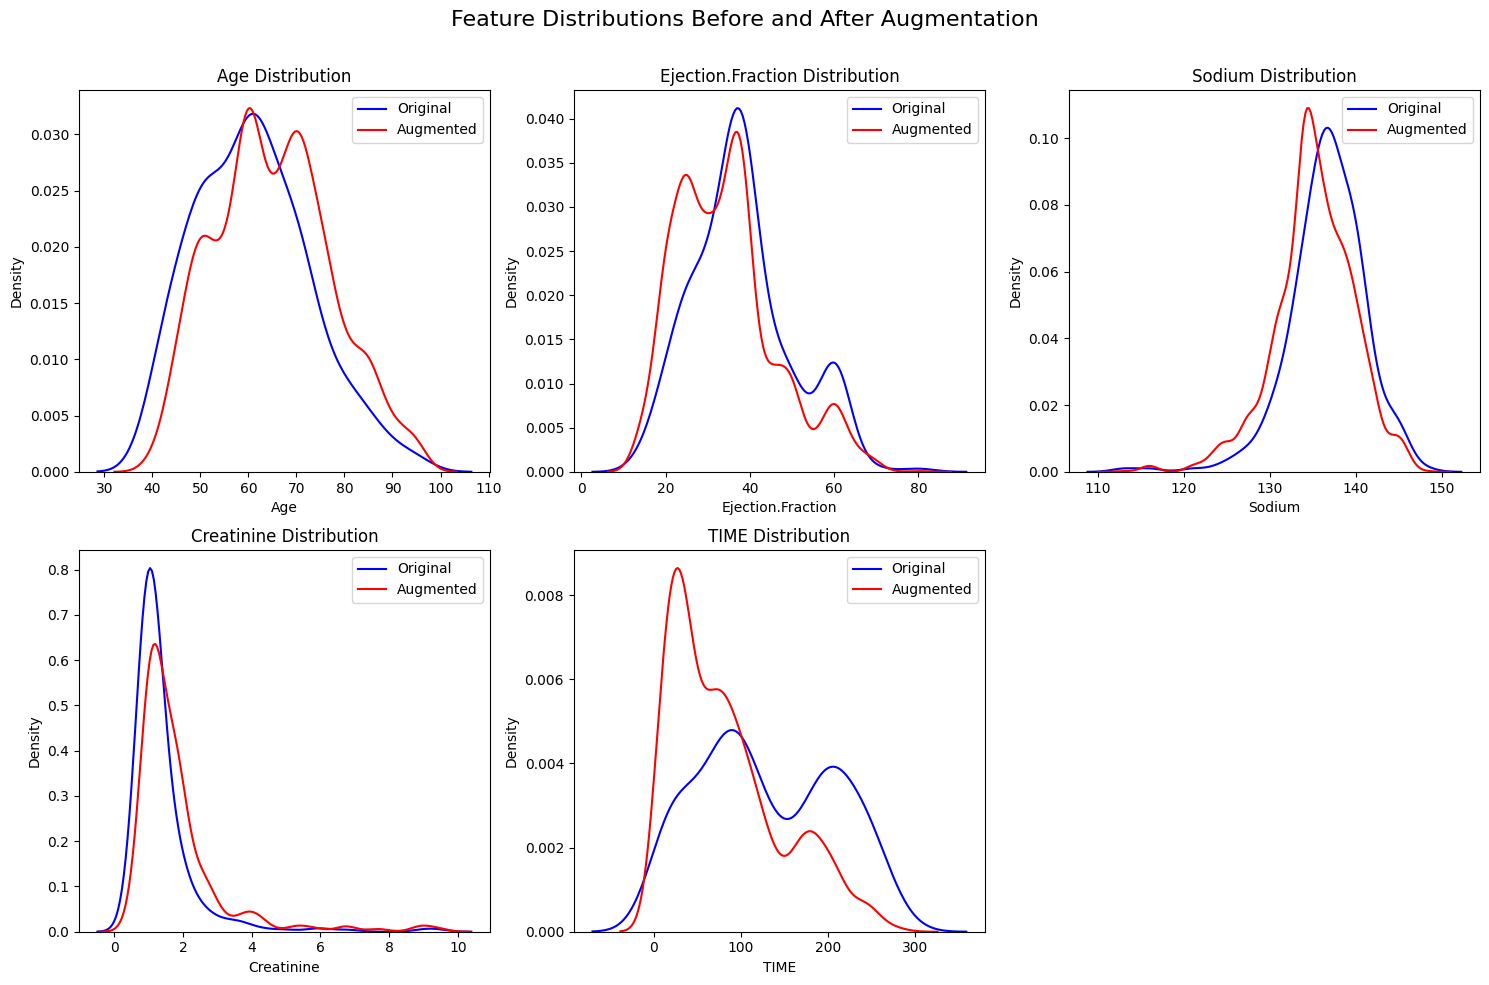


Class distribution before augmentation:
Event
0    203
1     96
Name: count, dtype: int64

Class distribution after augmentation:
Event
1.0    1827
0.0     203
Name: count, dtype: int64

Augmented dataset saved to 'augmented_heart_failure_data.csv'


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the original dataset
df = pd.read_csv('S1Data.csv')

# Function to visualize data distribution before and after augmentation
def plot_distributions(original_df, augmented_df, features, title):
    """
    Visualize the distribution of features before and after augmentation
    
    Args:
        original_df: Original dataframe
        augmented_df: Augmented dataframe
        features: List of features to visualize
        title: Title for the plot
    """
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features):
        plt.subplot(2, 3, i+1)
        sns.kdeplot(original_df[feature], label='Original', color='blue')
        sns.kdeplot(augmented_df[feature], label='Augmented', color='red')
        plt.title(f'{feature} Distribution')
        plt.legend()
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# 1. SMOTE: Synthetic Minority Over-sampling Technique
#----------------------------------------------------
def apply_smote(df, target_column='Event', categorical_features=None):
    """
    Apply SMOTE to balance the dataset
    
    Args:
        df: Input dataframe
        target_column: Target variable column name
        categorical_features: List of categorical feature indices
        
    Returns:
        DataFrame with synthetic samples added
    """
    print("Applying SMOTE augmentation...")
    
    # Separate features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Track original column order
    original_columns = X.columns.tolist()
    
    # Convert categorical features to integers if needed
    if categorical_features is not None:
        for cat_feature in categorical_features:
            if cat_feature in X.columns:
                X[cat_feature] = X[cat_feature].astype(int)
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Recreate the dataframe
    augmented_df = pd.DataFrame(X_resampled, columns=original_columns)
    augmented_df[target_column] = y_resampled
    
    # For categorical features, round to nearest integer
    if categorical_features is not None:
        for cat_feature in categorical_features:
            if cat_feature in augmented_df.columns:
                augmented_df[cat_feature] = augmented_df[cat_feature].round().astype(int)
    
    print(f"Original class distribution: {pd.Series(y).value_counts().to_dict()}")
    print(f"Augmented class distribution: {pd.Series(y_resampled).value_counts().to_dict()}")
    
    # Identify synthetic samples (those that were added by SMOTE)
    synthetic_samples = augmented_df.iloc[len(df):]
    
    return augmented_df, synthetic_samples

# 2. Advanced SMOTE Variants
#--------------------------
def apply_advanced_smote(df, variant='borderline', target_column='Event', categorical_features=None):
    """
    Apply advanced SMOTE variants
    
    Args:
        df: Input dataframe
        variant: 'borderline' or 'adasyn'
        target_column: Target variable column name
        categorical_features: List of categorical feature indices
        
    Returns:
        DataFrame with synthetic samples added
    """
    print(f"Applying {variant.upper()} augmentation...")
    
    # Separate features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Track original column order
    original_columns = X.columns.tolist()
    
    # Apply the selected variant
    if variant.lower() == 'borderline':
        oversampler = BorderlineSMOTE(random_state=42)
    elif variant.lower() == 'adasyn':
        oversampler = ADASYN(random_state=42)
    else:
        raise ValueError("Variant must be 'borderline' or 'adasyn'")
    
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    
    # Recreate the dataframe
    augmented_df = pd.DataFrame(X_resampled, columns=original_columns)
    augmented_df[target_column] = y_resampled
    
    # For categorical features, round to nearest integer
    if categorical_features is not None:
        for cat_feature in categorical_features:
            if cat_feature in augmented_df.columns:
                augmented_df[cat_feature] = augmented_df[cat_feature].round().astype(int)
    
    print(f"Original class distribution: {pd.Series(y).value_counts().to_dict()}")
    print(f"Augmented class distribution: {pd.Series(y_resampled).value_counts().to_dict()}")
    
    return augmented_df

# 3. Gaussian Noise Addition
#--------------------------
def add_gaussian_noise(df, numeric_features, noise_level=0.05, target_column='Event'):
    """
    Add Gaussian noise to numerical features
    
    Args:
        df: Input dataframe
        numeric_features: List of numerical feature names
        noise_level: Standard deviation of noise as a fraction of feature std
        target_column: Target variable column name
        
    Returns:
        DataFrame with noise added to copies of original samples
    """
    print("Applying Gaussian noise augmentation...")
    
    # Create a copy of the dataframe
    augmented_df = df.copy()
    
    # Create copies of the minority class with added noise
    minority_class = df[df[target_column] == 1]  # Assuming 1 is the minority class
    noisy_samples = []
    
    for _ in range(2):  # Create 2 noisy copies of each minority sample
        noisy_df = minority_class.copy()
        
        for feature in numeric_features:
            if feature in df.columns:
                # Calculate feature std
                feature_std = df[feature].std()
                # Add Gaussian noise
                noise = np.random.normal(0, noise_level * feature_std, size=len(noisy_df))
                noisy_df[feature] = noisy_df[feature] + noise
        
        noisy_samples.append(noisy_df)
    
    # Combine original and noisy samples
    augmented_df = pd.concat([augmented_df] + noisy_samples, ignore_index=True)
    
    print(f"Original shape: {df.shape}")
    print(f"Augmented shape: {augmented_df.shape}")
    
    return augmented_df

# 4. Random Sampling with Replacement
#----------------------------------
def random_oversampling(df, target_column='Event', minority_class=1, sampling_strategy=1.0):
    """
    Perform random oversampling of the minority class
    
    Args:
        df: Input dataframe
        target_column: Target variable column name
        minority_class: Value of the minority class
        sampling_strategy: Ratio of minority to majority class
        
    Returns:
        DataFrame with random oversampling applied
    """
    print("Applying random oversampling...")
    
    # Separate majority and minority classes
    majority_df = df[df[target_column] != minority_class]
    minority_df = df[df[target_column] == minority_class]
    
    # Calculate how many minority samples to generate
    n_majority = len(majority_df)
    n_minority = len(minority_df)
    n_to_add = int(n_majority * sampling_strategy) - n_minority
    
    if n_to_add <= 0:
        print("No oversampling needed with current sampling strategy")
        return df
    
    # Randomly sample with replacement from minority class
    oversampled = minority_df.sample(n=n_to_add, replace=True, random_state=42)
    
    # Combine with original data
    augmented_df = pd.concat([df, oversampled], ignore_index=True)
    
    print(f"Original class distribution: {df[target_column].value_counts().to_dict()}")
    print(f"Augmented class distribution: {augmented_df[target_column].value_counts().to_dict()}")
    
    return augmented_df

# 5. Mixed Sampling: Combine Under and Oversampling
#-------------------------------------------------
def mixed_sampling(df, target_column='Event', minority_class=1, majority_to_minority_ratio=1.5):
    """
    Combined approach using both undersampling of majority class and oversampling of minority class
    
    Args:
        df: Input dataframe
        target_column: Target variable column name
        minority_class: Value of the minority class
        majority_to_minority_ratio: Desired ratio of majority to minority samples
        
    Returns:
        Balanced DataFrame using mixed sampling approach
    """
    print("Applying mixed sampling approach...")
    
    # Separate by class
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Calculate desired sampling strategy based on ratio
    minority_count = (y == minority_class).sum()
    majority_count = (y != minority_class).sum()
    
    if majority_count / minority_count <= majority_to_minority_ratio:
        print("No mixed sampling needed, ratio already satisfied")
        return df
    
    # Apply random under-sampling
    desired_majority_count = int(minority_count * majority_to_minority_ratio)
    
    # Under-sample the majority class
    rus = RandomUnderSampler(
        sampling_strategy={minority_class: minority_count, 
                           1 - minority_class: desired_majority_count},
        random_state=42
    )
    X_undersampled, y_undersampled = rus.fit_resample(X, y)
    
    # Apply SMOTE to further balance if needed
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_undersampled, y_undersampled)
    
    # Create the final dataframe
    columns = X.columns.tolist()
    augmented_df = pd.DataFrame(X_resampled, columns=columns)
    augmented_df[target_column] = y_resampled
    
    print(f"Original class distribution: {pd.Series(y).value_counts().to_dict()}")
    print(f"Augmented class distribution: {pd.Series(y_resampled).value_counts().to_dict()}")
    
    return augmented_df

# 6. Generation of Realistic Synthetic Samples using KNN
#------------------------------------------------------
def knn_synthetic_generation(df, target_column='Event', minority_class=1, n_neighbors=3):
    """
    Generate realistic synthetic samples using k-nearest neighbors
    This method preserves feature correlations better than basic SMOTE
    
    Args:
        df: Input dataframe
        target_column: Target variable column name
        minority_class: Value of the minority class
        n_neighbors: Number of neighbors to consider
        
    Returns:
        DataFrame with synthetic samples added
    """
    print("Applying KNN-based synthetic data generation...")
    
    # Separate features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Separate by class
    X_minority = X_scaled[y == minority_class]
    original_minority_indices = np.where(y == minority_class)[0]
    
    # Count required samples
    n_minority = len(X_minority)
    n_majority = len(X_scaled) - n_minority
    n_to_generate = n_majority - n_minority  # Balance classes
    
    if n_to_generate <= 0:
        print("No synthetic samples needed, classes already balanced")
        return df
    
    # Generate synthetic samples
    synthetic_samples = []
    
    for _ in range(n_to_generate):
        # Randomly select a minority sample
        base_idx = np.random.randint(0, n_minority)
        base_sample = X_minority[base_idx]
        
        # Find nearest neighbors
        distances = np.sqrt(((X_minority - base_sample) ** 2).sum(axis=1))
        nearest_indices = np.argsort(distances)[1:n_neighbors+1]  # Exclude itself
        
        # Choose a random neighbor
        neighbor_idx = np.random.choice(nearest_indices)
        neighbor = X_minority[neighbor_idx]
        
        # Generate synthetic sample between base and neighbor
        alpha = np.random.random()
        synthetic = base_sample + alpha * (neighbor - base_sample)
        
        synthetic_samples.append(synthetic)
    
    # Convert synthetic samples back to original scale
    synthetic_array = np.array(synthetic_samples)
    synthetic_original_scale = scaler.inverse_transform(synthetic_array)
    
    # Create DataFrame for synthetic samples
    synthetic_df = pd.DataFrame(synthetic_original_scale, columns=X.columns)
    synthetic_df[target_column] = minority_class
    
    # For any categorical features, round to nearest integer
    categorical_features = ['Gender', 'Smoking', 'Diabetes', 'BP', 'Anaemia', 'Ejection.Fraction']
    for feature in categorical_features:
        if feature in synthetic_df.columns:
            synthetic_df[feature] = synthetic_df[feature].round().astype(int)
    
    # Combine with original data
    augmented_df = pd.concat([df, synthetic_df], ignore_index=True)
    
    print(f"Original class distribution: {pd.Series(y).value_counts().to_dict()}")
    print(f"Augmented class distribution: {augmented_df[target_column].value_counts().to_dict()}")
    
    return augmented_df

# 7. Time-based Data Augmentation for Survival Data
#-------------------------------------------------
def survival_specific_augmentation(df, time_column='TIME', event_column='Event'):
    """
    Augmentation technique specific for survival analysis data
    This preserves the time-to-event relationship
    
    Args:
        df: Input dataframe
        time_column: Column containing time-to-event data
        event_column: Column containing event indicator
        
    Returns:
        DataFrame with augmented survival data
    """
    print("Applying survival-specific augmentation...")
    
    # Separate censored and event cases
    event_cases = df[df[event_column] == 1].copy()
    censored_cases = df[df[event_column] == 0].copy()
    
    # For event cases, we can create realistic variations by slightly changing the event time
    augmented_events = []
    
    for _, row in event_cases.iterrows():
        # Create 2 variations with slightly modified times
        for _ in range(2):
            new_row = row.copy()
            
            # Modify the time with a small random factor (±10%)
            time_variation = random.uniform(0.9, 1.1)
            new_time = max(1, int(row[time_column] * time_variation))  # Ensure time > 0
            new_row[time_column] = new_time
            
            augmented_events.append(new_row)
    
    # Convert to DataFrame
    augmented_events_df = pd.DataFrame(augmented_events)
    
    # Combine with original data
    augmented_df = pd.concat([df, augmented_events_df], ignore_index=True)
    
    print(f"Original shape: {df.shape}")
    print(f"Augmented shape: {augmented_df.shape}")
    print(f"Original event count: {len(event_cases)}")
    print(f"Added synthetic event cases: {len(augmented_events_df)}")
    
    return augmented_df

# 8. Balanced-Batch Data Augmentation
#-----------------------------------
def balanced_batch_augmentation(df, target_column='Event', batch_size=10):
    """
    Create balanced batches of data with augmentation
    Useful for training deep learning models
    
    Args:
        df: Input dataframe
        target_column: Target variable column name
        batch_size: Size of batches to generate
        
    Returns:
        Function to generate balanced batches
    """
    # Separate by class
    class_0 = df[df[target_column] == 0]
    class_1 = df[df[target_column] == 1]
    
    def generate_batch():
        """Generate a balanced batch of data"""
        # Randomly sample from each class
        batch_size_per_class = batch_size // 2
        
        # Sample with replacement if necessary
        batch_0 = class_0.sample(n=batch_size_per_class, replace=len(class_0) < batch_size_per_class)
        batch_1 = class_1.sample(n=batch_size_per_class, replace=len(class_1) < batch_size_per_class)
        
        # Combine
        batch = pd.concat([batch_0, batch_1], ignore_index=True)
        
        # Shuffle
        batch = batch.sample(frac=1).reset_index(drop=True)
        
        return batch
    
    return generate_batch

# 9. Feature-Correlating Augmentation
#----------------------------------
def feature_correlated_augmentation(df, target_column='Event', num_samples=100):
    """
    Generate synthetic samples that preserve feature correlations
    
    Args:
        df: Input dataframe
        target_column: Target variable column name
        num_samples: Number of synthetic samples to generate
        
    Returns:
        DataFrame with correlated synthetic samples added
    """
    print("Applying feature-correlated augmentation...")
    
    # Separate features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Calculate correlation matrix
    corr_matrix = X.corr().values
    
    # Get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(corr_matrix)
    
    # Create synthetic samples that maintain the correlation structure
    synthetic_samples = []
    
    for class_value in [0, 1]:
        # Filter data by class
        X_class = X[y == class_value].values
        
        if len(X_class) == 0:
            continue
            
        # Calculate class mean
        class_mean = X_class.mean(axis=0)
        
        # Generate samples
        for _ in range(num_samples // 2):
            # Generate random values from standard normal distribution
            random_vector = np.random.normal(0, 1, size=len(eigenvalues))
            
            # Transform using eigenvalues/eigenvectors to maintain correlation
            # Note: We use the square root of eigenvalues to scale properly
            random_sample = class_mean + eigenvectors @ (np.sqrt(np.maximum(eigenvalues, 0)) * random_vector)
            
            synthetic_samples.append(np.real(random_sample))  # Ensure real values
    
    # Convert to DataFrame
    synthetic_df = pd.DataFrame(synthetic_samples, columns=X.columns)
    
    # Assign target values (evenly split between classes)
    synthetic_df[target_column] = [0] * (num_samples // 2) + [1] * (num_samples // 2)
    
    # Process categorical features
    categorical_features = ['Gender', 'Smoking', 'Diabetes', 'BP', 'Anaemia', 'Ejection.Fraction']
    for feature in categorical_features:
        if feature in synthetic_df.columns:
            # Round and clip to valid values (0 or 1 for binary features)
            synthetic_df[feature] = np.round(synthetic_df[feature]).clip(0, 1).astype(int)
    
    # Process numerical features to ensure they're within reasonable ranges
    for col in synthetic_df.columns:
        if col not in categorical_features and col != target_column:
            min_val = df[col].min()
            max_val = df[col].max()
            synthetic_df[col] = synthetic_df[col].clip(min_val, max_val)
    
    # Combine with original data
    augmented_df = pd.concat([df, synthetic_df], ignore_index=True)
    
    print(f"Original shape: {df.shape}")
    print(f"Augmented shape: {augmented_df.shape}")
    
    return augmented_df

# 10. Integrated Augmentation Pipeline
#------------------------------------
def create_augmentation_pipeline(df, target_column='Event', strategies=None, 
                               categorical_features=None, numerical_features=None):
    """
    Create a comprehensive augmentation pipeline that combines multiple strategies
    
    Args:
        df: Input dataframe
        target_column: Target variable column name
        strategies: List of augmentation strategies to apply
        categorical_features: List of categorical feature names
        numerical_features: List of numerical feature names
        
    Returns:
        DataFrame with combined augmentation strategies applied
    """
    print("Applying comprehensive augmentation pipeline...")
    
    if strategies is None:
        strategies = ['smote', 'noise', 'survival']
    
    if categorical_features is None:
        categorical_features = ['Gender', 'Smoking', 'Diabetes', 'BP', 'Anaemia']
    
    if numerical_features is None:
        numerical_features = ['Age', 'Ejection.Fraction', 'Sodium', 'Creatinine', 
                             'Pletelets', 'CPK']
    
    # Start with original data
    augmented_df = df.copy()
    
    # Apply selected strategies
    for strategy in strategies:
        if strategy.lower() == 'smote':
            new_df, _ = apply_smote(augmented_df, target_column, categorical_features)
            augmented_df = new_df
        
        elif strategy.lower() == 'borderline':
            augmented_df = apply_advanced_smote(augmented_df, 'borderline', target_column, categorical_features)
        
        elif strategy.lower() == 'adasyn':
            augmented_df = apply_advanced_smote(augmented_df, 'adasyn', target_column, categorical_features)
        
        elif strategy.lower() == 'noise':
            augmented_df = add_gaussian_noise(augmented_df, numerical_features, 0.05, target_column)
        
        elif strategy.lower() == 'random':
            augmented_df = random_oversampling(augmented_df, target_column)
        
        elif strategy.lower() == 'mixed':
            augmented_df = mixed_sampling(augmented_df, target_column)
        
        elif strategy.lower() == 'knn':
            augmented_df = knn_synthetic_generation(augmented_df, target_column)
        
        elif strategy.lower() == 'survival':
            augmented_df = survival_specific_augmentation(augmented_df, 'TIME', target_column)
        
        elif strategy.lower() == 'correlated':
            augmented_df = feature_correlated_augmentation(augmented_df, target_column)
    
    print(f"Original shape: {df.shape}")
    print(f"Final augmented shape: {augmented_df.shape}")
    
    # Verify data integrity
    for col in categorical_features:
        if col in augmented_df.columns:
            unique_values = augmented_df[col].unique()
            print(f"Categorical feature '{col}' has values: {unique_values}")
    
    return augmented_df

# Example usage
if __name__ == "__main__":
    # Define feature types
    categorical_features = ['Gender', 'Smoking', 'Diabetes', 'BP', 'Anaemia']
    numerical_features = ['Age', 'Ejection.Fraction', 'Sodium', 'Creatinine', 'Pletelets', 'CPK']
    
    # 1. Simple SMOTE example
    augmented_df_smote, _ = apply_smote(df, 'Event', categorical_features)
    
    # 2. Combination approach
    augmented_df_combined = create_augmentation_pipeline(
        df, 
        target_column='Event',
        strategies=['smote', 'noise', 'survival'],
        categorical_features=categorical_features,
        numerical_features=numerical_features
    )
    
    # Visualize distributions before and after augmentation
    plot_distributions(
        df, 
        augmented_df_combined,
        ['Age', 'Ejection.Fraction', 'Sodium', 'Creatinine', 'TIME'],
        'Feature Distributions Before and After Augmentation'
    )
    
    # Check class balance before and after
    print("\nClass distribution before augmentation:")
    print(df['Event'].value_counts())
    
    print("\nClass distribution after augmentation:")
    print(augmented_df_combined['Event'].value_counts())
    
    # Save the augmented dataset
    augmented_df_combined.to_csv('augmented_heart_failure_data.csv', index=False)
    print("\nAugmented dataset saved to 'augmented_heart_failure_data.csv'")

Running Ensemble Models for Heart Failure Prediction

==== Random Forest Classifier ====
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.61      0.76        41
         1.0       0.96      1.00      0.98       365

    accuracy                           0.96       406
   macro avg       0.98      0.80      0.87       406
weighted avg       0.96      0.96      0.96       406

ROC-AUC Score: 0.9989


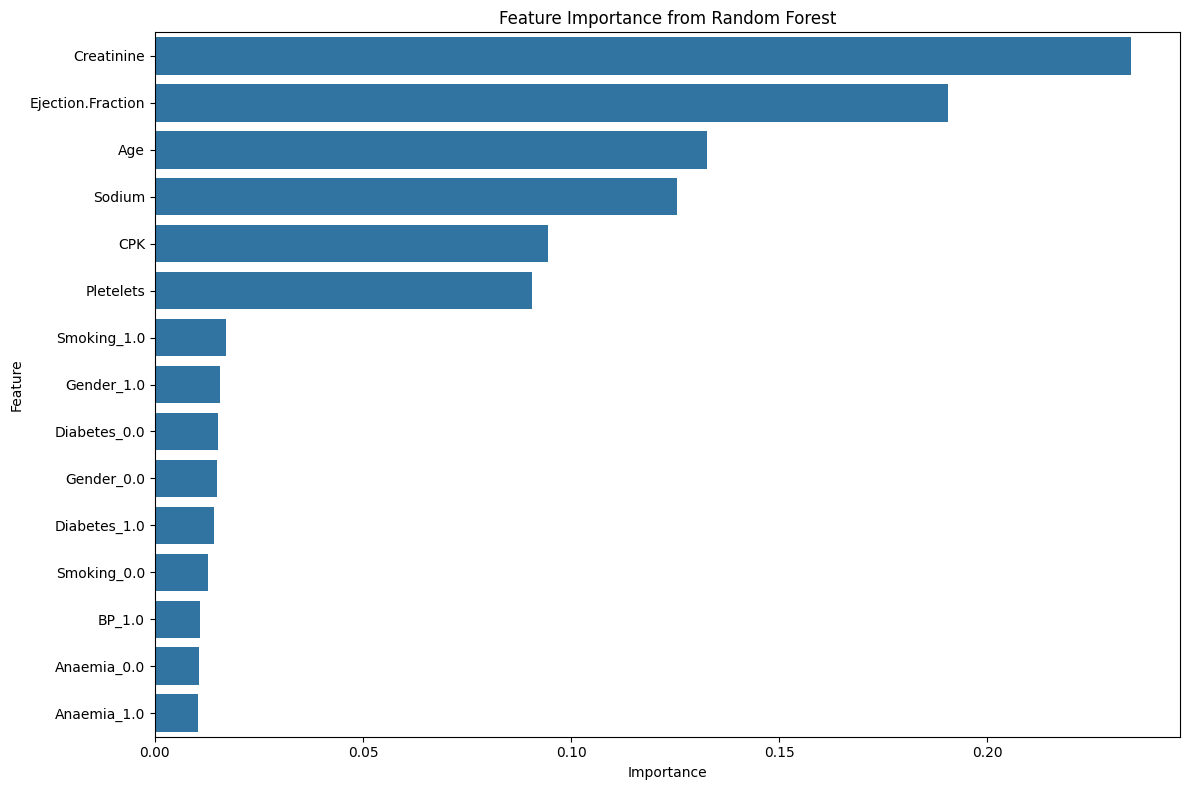


==== Bagging Classifier ====
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.46      0.63        41
         1.0       0.94      1.00      0.97       365

    accuracy                           0.95       406
   macro avg       0.97      0.73      0.80       406
weighted avg       0.95      0.95      0.94       406

ROC-AUC Score: 0.9976

==== AdaBoost Classifier ====
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.27      0.42        41
         1.0       0.92      1.00      0.96       365

    accuracy                           0.93       406
   macro avg       0.96      0.63      0.69       406
weighted avg       0.93      0.93      0.91       406

ROC-AUC Score: 0.9021


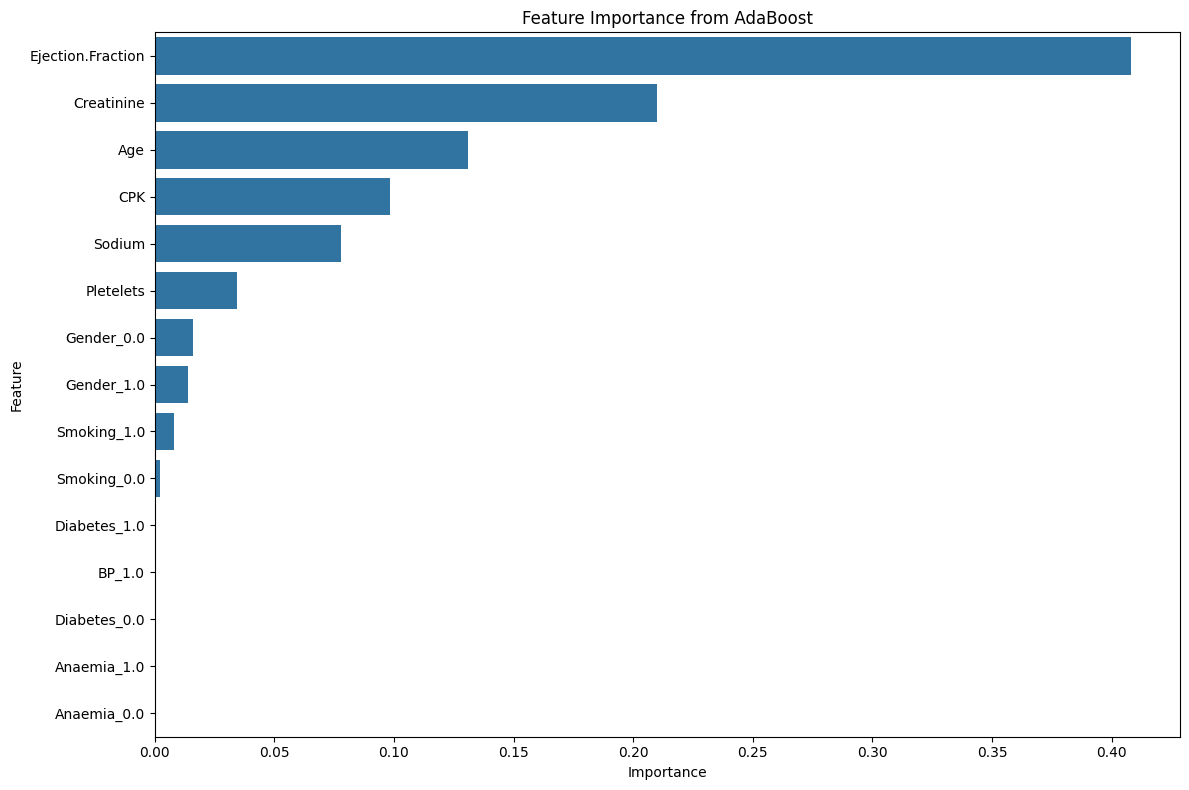


==== Gradient Boosting Classifier ====
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.44      0.61        41
         1.0       0.94      1.00      0.97       365

    accuracy                           0.94       406
   macro avg       0.97      0.72      0.79       406
weighted avg       0.95      0.94      0.93       406

ROC-AUC Score: 0.9081


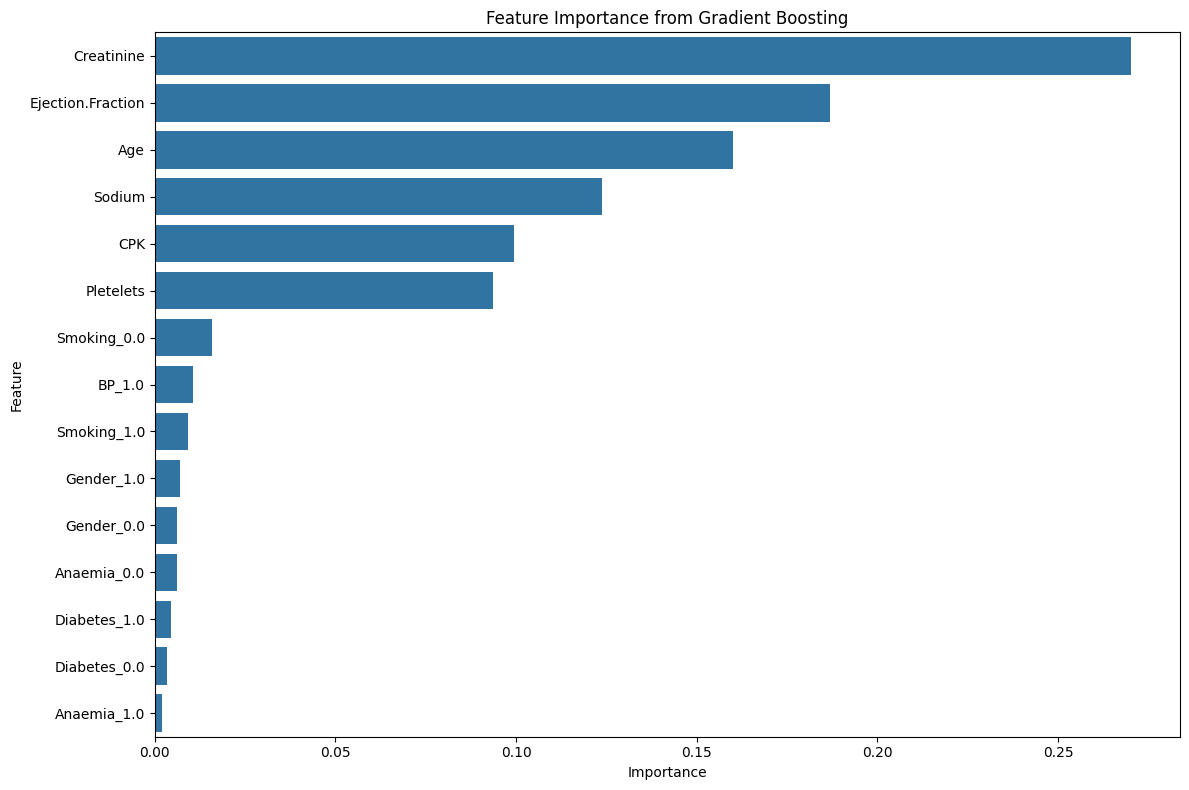

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


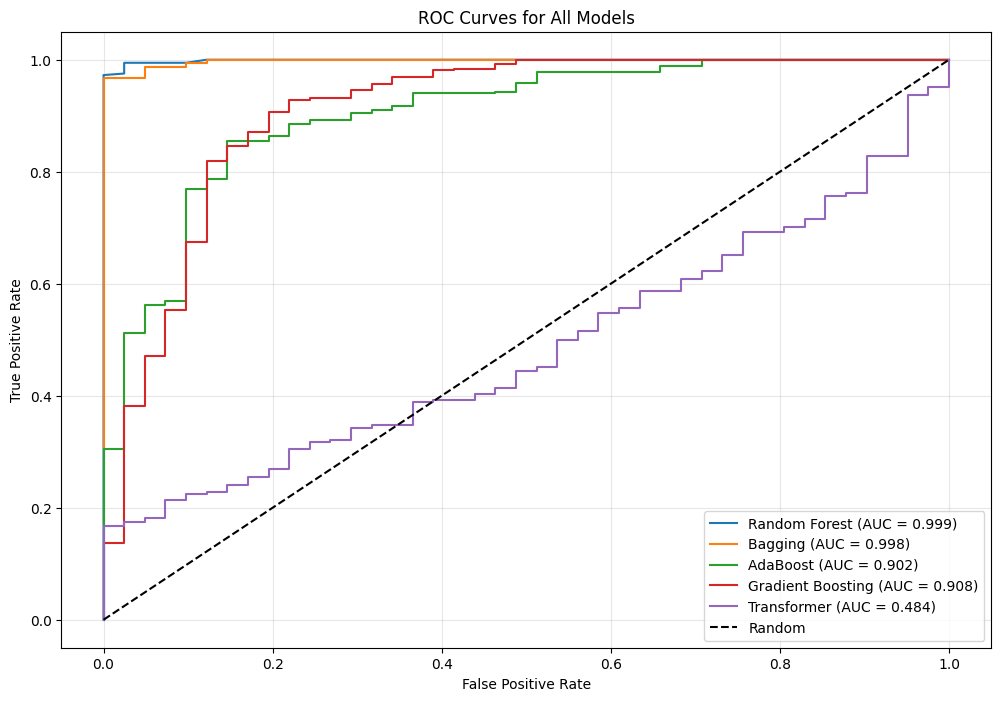

<Figure size 1400x800 with 0 Axes>

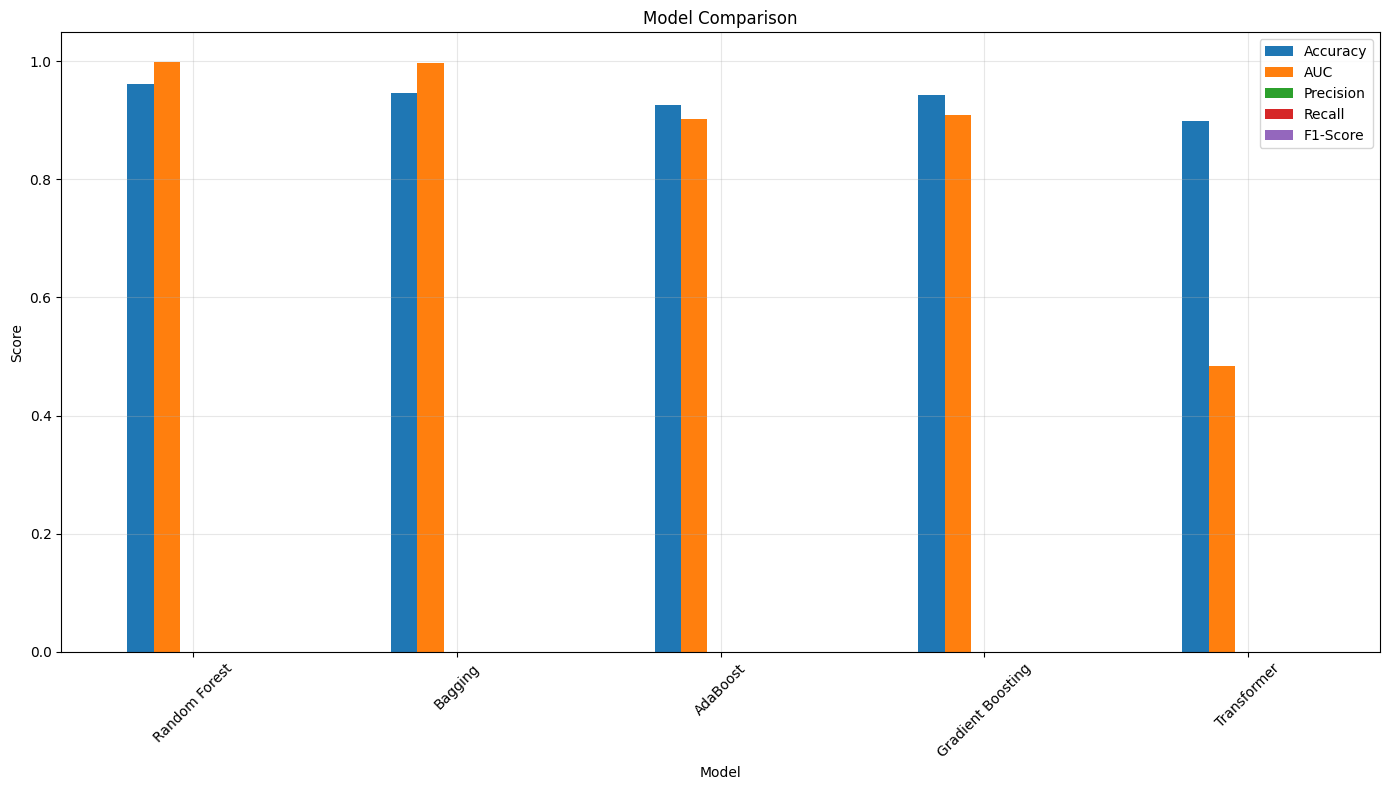


Model Comparison Summary:
                   Accuracy       AUC  Precision  Recall  F1-Score
Random Forest      0.960591  0.998897        NaN     NaN       NaN
Bagging            0.945813  0.997594        NaN     NaN       NaN
AdaBoost           0.926108  0.902105        NaN     NaN       NaN
Gradient Boosting  0.943350  0.908119        NaN     NaN       NaN
Transformer        0.899015  0.484263        NaN     NaN       NaN


In [9]:
# Import necessary libraries for ensemble methods
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# ----------------------
# 1. Random Forest Model
# ----------------------
def train_evaluate_random_forest(X_train_processed, X_test_processed, y_train, y_test):
    print("\n==== Random Forest Classifier ====")
    
    # Initialize and train Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=True,
        random_state=42,
        class_weight='balanced'
    )
    
    rf_model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_pred_proba_rf = rf_model.predict_proba(X_test_processed)[:, 1]
    y_pred_rf = (y_pred_proba_rf > 0.5).astype(int)
    
    # Evaluate
    print("Classification Report:")
    print(classification_report(y_test, y_pred_rf))
    
    roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    # Feature importance
    if hasattr(rf_model, 'feature_importances_'):
        feature_names = get_feature_names(preprocessor)
        if len(feature_names) == rf_model.feature_importances_.shape[0]:
            plot_feature_importance(rf_model.feature_importances_, feature_names, "Random Forest")
    
    return rf_model, y_pred_proba_rf

# -----------------------
# 2. Bagging Classifier
# -----------------------
def train_evaluate_bagging(X_train_processed, X_test_processed, y_train, y_test):
    print("\n==== Bagging Classifier ====")
    
    # Initialize base estimator
    base_estimator = DecisionTreeClassifier(max_depth=10, random_state=42)
    
    # Initialize and train Bagging model
    bagging_model = BaggingClassifier(
        estimator=base_estimator,
        n_estimators=100,
        max_samples=0.8,
        max_features=0.8,
        bootstrap=True,
        bootstrap_features=False,
        random_state=42
    )
    
    bagging_model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_pred_proba_bagging = bagging_model.predict_proba(X_test_processed)[:, 1]
    y_pred_bagging = (y_pred_proba_bagging > 0.5).astype(int)
    
    # Evaluate
    print("Classification Report:")
    print(classification_report(y_test, y_pred_bagging))
    
    roc_auc = roc_auc_score(y_test, y_pred_proba_bagging)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    return bagging_model, y_pred_proba_bagging

# -----------------------
# 3. AdaBoost Classifier
# -----------------------
def train_evaluate_adaboost(X_train_processed, X_test_processed, y_train, y_test):
    print("\n==== AdaBoost Classifier ====")
    
    # Initialize base estimator
    estimator = DecisionTreeClassifier(max_depth=3, random_state=42)
    
    # Initialize and train AdaBoost model
    adaboost_model = AdaBoostClassifier(
        estimator=estimator,
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
    
    adaboost_model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_pred_proba_adaboost = adaboost_model.predict_proba(X_test_processed)[:, 1]
    y_pred_adaboost = (y_pred_proba_adaboost > 0.5).astype(int)
    
    # Evaluate
    print("Classification Report:")
    print(classification_report(y_test, y_pred_adaboost))
    
    roc_auc = roc_auc_score(y_test, y_pred_proba_adaboost)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    # Feature importance
    if hasattr(adaboost_model, 'feature_importances_'):
        feature_names = get_feature_names(preprocessor)
        if len(feature_names) == adaboost_model.feature_importances_.shape[0]:
            plot_feature_importance(adaboost_model.feature_importances_, feature_names, "AdaBoost")
    
    return adaboost_model, y_pred_proba_adaboost

# -------------------------------
# 4. Gradient Boosting Classifier
# -------------------------------
def train_evaluate_gradient_boosting(X_train_processed, X_test_processed, y_train, y_test):
    print("\n==== Gradient Boosting Classifier ====")
    
    # Initialize and train Gradient Boosting model
    gb_model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=1,
        subsample=0.8,
        max_features='sqrt',
        random_state=42
    )
    
    gb_model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_pred_proba_gb = gb_model.predict_proba(X_test_processed)[:, 1]
    y_pred_gb = (y_pred_proba_gb > 0.5).astype(int)
    
    # Evaluate
    print("Classification Report:")
    print(classification_report(y_test, y_pred_gb))
    
    roc_auc = roc_auc_score(y_test, y_pred_proba_gb)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    # Feature importance
    if hasattr(gb_model, 'feature_importances_'):
        feature_names = get_feature_names(preprocessor)
        if len(feature_names) == gb_model.feature_importances_.shape[0]:
            plot_feature_importance(gb_model.feature_importances_, feature_names, "Gradient Boosting")
    
    return gb_model, y_pred_proba_gb

# -------------------------------
# Utility Functions
# -------------------------------

def get_feature_names(preprocessor):
    """Extract feature names from the column transformer"""
    feature_names = []
    
    # Get all transformers
    transformers = preprocessor.transformers_
    
    # Iterate through all transformers
    for name, transformer, columns in transformers:
        if name == 'num':
            # For numerical features
            feature_names.extend(columns)
        elif name == 'cat':
            # For one-hot encoded categorical features
            ohe = transformer.named_steps['onehot']
            for i, col in enumerate(columns):
                categories = ohe.categories_[i]
                for category in categories:
                    feature_names.append(f"{col}_{category}")
    
    return feature_names

def plot_feature_importance(importances, feature_names, model_name):
    """Plot feature importance"""
    # Create DataFrame of feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names[:len(importances)],  # Ensure lengths match
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot top 15 features for clarity
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
    plt.title(f'Feature Importance from {model_name}')
    plt.tight_layout()
    plt.show()

def plot_roc_curves(model_results, y_test):
    """Plot ROC curves for all models"""
    plt.figure(figsize=(12, 8))
    
    for model_name, y_pred_proba in model_results.items():
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def compare_models(model_results, y_test):
    """Compare all models using various metrics"""
    results = {}
    
    for model_name, y_pred_proba in model_results.items():
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        results[model_name] = {
            'Accuracy': accuracy,
            'AUC': auc,
            'Precision': report['1']['precision'] if '1' in report else None,
            'Recall': report['1']['recall'] if '1' in report else None,
            'F1-Score': report['1']['f1-score'] if '1' in report else None
        }
    
    # Create DataFrame for easier comparison
    results_df = pd.DataFrame(results).T
    
    # Plot comparison
    plt.figure(figsize=(14, 8))
    results_df.plot(kind='bar', figsize=(14, 8))
    plt.title('Model Comparison')
    plt.ylabel('Score')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results_df

# -------------------------------
# Main Execution
# -------------------------------

def run_ensemble_models():
    """Run all ensemble models and compare results"""
    print("Running Ensemble Models for Heart Failure Prediction")
    
    # Dictionary to store model results
    model_results = {}
    
    # 1. Train and evaluate Random Forest
    rf_model, y_pred_proba_rf = train_evaluate_random_forest(
        X_train_processed, X_test_processed, y_train, y_test
    )
    model_results['Random Forest'] = y_pred_proba_rf
    
    # 2. Train and evaluate Bagging
    bagging_model, y_pred_proba_bagging = train_evaluate_bagging(
        X_train_processed, X_test_processed, y_train, y_test
    )
    model_results['Bagging'] = y_pred_proba_bagging
    
    # 3. Train and evaluate AdaBoost
    adaboost_model, y_pred_proba_adaboost = train_evaluate_adaboost(
        X_train_processed, X_test_processed, y_train, y_test
    )
    model_results['AdaBoost'] = y_pred_proba_adaboost
    
    # 4. Train and evaluate Gradient Boosting
    gb_model, y_pred_proba_gb = train_evaluate_gradient_boosting(
        X_train_processed, X_test_processed, y_train, y_test
    )
    model_results['Gradient Boosting'] = y_pred_proba_gb
    
    # 5. Add transformer model results if available 
    # (assuming you've already run the transformer model code)
    try:
        y_pred_proba_transformer = model.predict(X_test_seq)
        model_results['Transformer'] = y_pred_proba_transformer.flatten()
    except:
        print("Note: Transformer model results not included in comparison.")
    
    # 6. Plot ROC curves for all models
    plot_roc_curves(model_results, y_test)
    
    # 7. Compare all models
    results_df = compare_models(model_results, y_test)
    print("\nModel Comparison Summary:")
    print(results_df)
    
    return {
        'random_forest': rf_model,
        'bagging': bagging_model,
        'adaboost': adaboost_model,
        'gradient_boosting': gb_model,
        'results_comparison': results_df
    }

# Run the ensemble model analysis
ensemble_models = run_ensemble_models()